# Static Bayesian Optimization: 
- initial training on burnin points
- use acquisition function to guide next sampling
- re-optimize the model
- plot and visualize before and after
- loop and use acquistion function for up to 100 samples. 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, ker_BaO, 
                               slice_dim, ylabel, initialize_data_dr_sim):
        # TODO: clean up and fix this function
        sampling_freq = np.empty((n_samples))
        sampling_freq[:] = 35
        sampling_amp = np.empty((n_samples))
        sampling_amp[:] = 40

        testX_BaO = np.array([sampling_freq, sampling_amp])
        testX = np.transpose(testX_BaO)
        
        state_est_BaO = np.empty((n_samples,1))
        simY_BaO = np.empty((n_samples, 1))
        simMse_BaO = np.empty((n_samples, 1))

        for i in range(n_samples-1):
            state_est_BaO[i:i+2, 0], simY_BaO[i:i+2,0:1], simMse_BaO[i:i+2,0:1] = self.sample(testX_BaO, trained_model_BaO);

        print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])
        
        nu = 0.1
        print("nu set at: ", nu)
        ucb = np.empty((1))
        freq_choices = [5,7,11,17, 23, 35, 42]

        ucb= self.acquisition_function(simY_BaO, simMse_BaO, nu, 1)
        median_ucb = np.median(ucb)
        next_freq_idx = abs(median_ucb-freq_choices).argmin()
          
        for idx in range(n_samples, np.shape(U1)[0]):
            if U1.loc[idx,'Stim_1']==freq_choices[next_freq_idx]:
                # print(idx)
                next_idx_to_optimize.append(idx)
                if np.size(next_idx_to_optimize)>n_samples:
                    break
        
        U1_next = U1.loc[next_idx_to_optimize,:]
        X0_psd_next = X0_psd.loc[next_idx_to_optimize]
        X1_next = X1[next_idx_to_optimize,:]
        
        U1_combo = pd.concat([U1_init,U1_next])
        X0_psd_combo = pd.concat([X0_psd_init, X0_psd_next])
        X1_combo = np.append(X1_init, X1_next, axis=0)
        
        U1_combo.reset_index()
        U1_combo=U1_combo[['Stim_1', 'Stim_2']]

        X0_psd_combo.reset_index()
        X0_psd_combo= X0_psd_combo[['sum_preStim_gamma']]
        
        x_BaO, y_BaO, trained_model_BaO = self.initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)
        
        return x_BaO, y_BaO, trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
print('Sum preStim gamma are: \n', X0_psd, '\n','freq and amplitude used are: \n', U1[0:4])

Sum preStim gamma are: 
      sum_preStim_gamma
0             3.266571
1             2.425945
2             3.117866
3             2.868627
4             3.521665
..                 ...
379           1.268502
380           1.239859
381           1.880050
382           1.199899
383           1.343332

[384 rows x 1 columns] 
 freq and amplitude used are: 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [7]:
U1.loc[0:10, 'Stim_1']

0     17
1     42
2     35
3     23
4     42
5     35
6     11
7      7
8     17
9     11
10    17
Name: Stim_1, dtype: int64

In [8]:
print(np.shape(U1), np.shape(X0_psd))

(384, 2) (384, 1)


In [9]:
n_burn_in = 20
n_samples= 150
n_acquisition = 50

## 1.2 First BaO Model is trained on all of the dataset

In [10]:
ker_BaO = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [11]:
slice_dim = 1
ylabel='Predicted Gamma'

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x21cb5ce86d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x21cb5ce8af0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   3.584623e+03           nan 
    02s35  0011   1.137562e+03   5.071697e+00 
    06s11  0027   1.115299e+03   3.551007e-02 
    08s04  0034   1.115247e+03   6.434336e-10 
Runtime:     08s04
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x21cb4210b80>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x21cb5f0caf0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x21cb5f61370>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x21cb5f618b0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x21cb5f618e0>]}

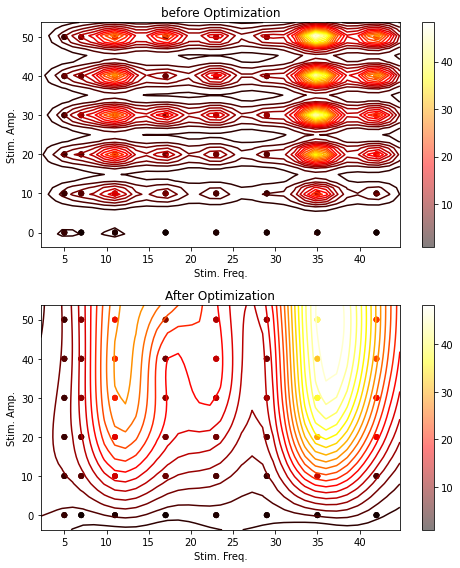

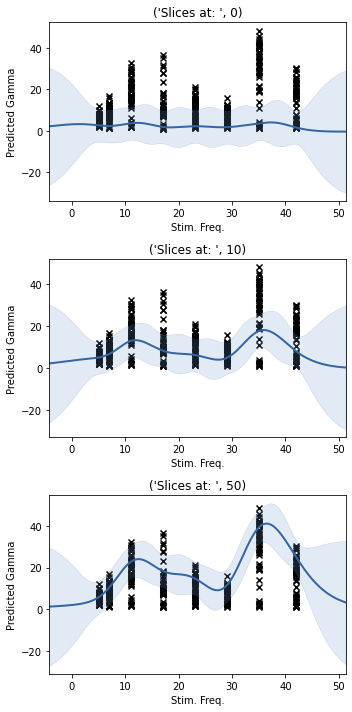

In [12]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

## 1.3: Train the second model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp/PreStimGamma 

- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [135]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:n_burn_in-1,:]
X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1[0:n_burn_in,:]
print('Sum preStim gamma are: \n', X0_psd_init, '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))

Sum preStim gamma are: 
     sum_preStim_gamma
0            3.266571
1            2.425945
2            3.117866
3            2.868627
4            3.521665
5            1.384478
6            1.420178
7            1.533292
8            2.019014
9            2.231953
10           2.347957
11           2.131811
12           1.934441
13           2.512154
14           4.690816
15           2.645199
16           6.401632
17           1.984354
18           3.580944
19           2.032816 
 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [

In [85]:
# input_data
U1_X0_init = U1_init.join(X0_psd_init)

#### initial training

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x21cc0a73be0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x21cc0a42c10>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s15  0006   7.021987e+01   3.274981e-01 
    00s29  0016   6.946105e+01   1.853847e-09 
Runtime:     00s29
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x21cc0ad4760>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x21cc0abb820>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x21cbc1b51c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x21cbc139f40>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x21cbc139310>]}

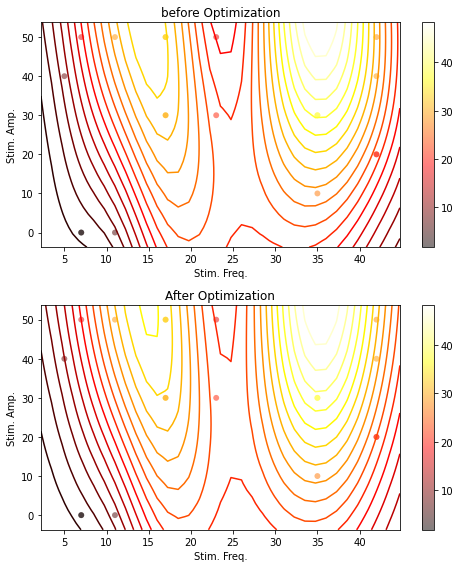

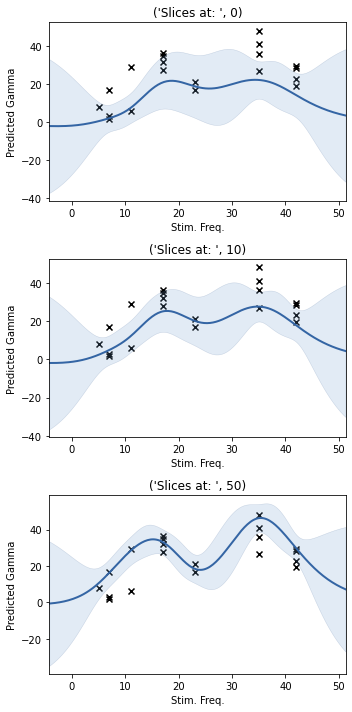

In [86]:
x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO, slice_dim, ylabel)

#### use the acquisition function to guide the next freq to optimize at

In [87]:
rand_freq_1d = np.random.choice(np.arange(1,43,1), size=(n_samples))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted)
rand_amp_1d = np.random.choice(np.arange(1,51,1), size=(n_samples))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))

[ 1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  5  5  6  6  6  6  6  7
  7  7  7  8  8  8  9  9  9  9  9 10 10 10 11 11 11 11 12 13 13 13 14 14
 14 14 14 15 15 15 15 15 15 16 16 16 16 17 17 18 18 18 18 18 19 19 20 20
 20 20 21 21 21 21 21 22 22 22 23 23 23 23 24 24 24 24 24 25 25 25 25 26
 26 26 26 27 27 28 28 28 28 28 28 29 30 31 31 31 31 32 32 32 33 33 33 33
 33 34 34 34 35 36 37 37 37 37 38 38 39 39 39 39 39 40 40 40 41 41 41 41
 41 41 42 42 42 42]
[ 1  2  2  2  3  3  4  5  5  5  5  5  5  6  6  6  7  7  7  8  8  8  8  9
  9  9  9  9 10 11 11 11 11 12 12 12 13 13 15 15 15 16 16 16 18 18 19 20
 20 20 20 21 21 21 22 22 22 24 24 24 25 26 26 26 26 27 27 27 27 28 29 29
 29 29 30 30 30 30 30 31 31 31 32 32 32 32 32 33 33 33 33 33 33 33 33 34
 34 35 35 36 37 38 38 38 39 39 39 40 40 40 40 40 41 41 41 42 43 43 43 43
 43 44 44 45 45 45 45 45 45 45 45 45 46 46 46 46 46 46 47 47 47 47 47 48
 48 49 49 50 50 50] (150,)


In [88]:
# sample mean preStimGamma
mean_preStimGamma = np.empty((n_samples,))
mean_preStimGamma[:] = np.mean(X0_psd, axis=0)
print(mean_preStimGamma[0], np.shape(mean_preStimGamma))

2.171337907722562 (150,)


In [89]:
print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted, mean_preStimGamma])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(testX_BaO[0:3, 0:3])

(150,) (150,)
(3, 150)
[[1.         1.         1.        ]
 [1.         2.         2.        ]
 [2.17133791 2.17133791 2.17133791]]


In [90]:
state_est_BaO_AF = np.empty((3, n_samples))
simY_BaO_AF = np.empty((3, n_samples))
simMse_BaO_AF = np.empty((3, n_samples))

for i in range(n_samples-1):
        # print(i)
    state_est_BaO_AF[:, i], simY_BaO_AF[:, i:i+1], simMse_BaO_AF[:, i:i+1] = model.sample(testX_BaO, trained_model_BaO_AF);

print("mean is: \n",simY_BaO_AF[0:3,0:3],"\n\n Variance is: \n", simMse_BaO_AF[0:3,0:3])
# posteriorTestY
print(np.shape(state_est_BaO_AF),'\n',state_est_BaO_AF[:,0:10])
print(np.shape(simY_BaO_AF),'\n', np.shape(simMse_BaO_AF))

mean is: 
 [[-1.52042248 -1.52042248 -1.52042248]
 [-1.45310456 -1.45310456 -1.45310456]
 [-0.94644866 -0.94644866 -0.94644866]] 

 Variance is: 
 [[130.04964317 130.04964317 130.04964317]
 [128.34053908 128.34053908 128.34053908]
 [ 88.46078469  88.46078469  88.46078469]]
(3, 150) 
 [[ 6.72929374  0.36639087  6.86315402 -8.12607907 -1.93975517 -3.52532589
   4.2893341  -1.71106004 11.73231536 -1.10594085]
 [ 6.8760329   0.21020955  7.07718072 -7.57032159 -1.97180915 -3.27014641
   3.69740139 -1.69116599 11.56243156 -0.69993599]
 [ 2.42738608  0.96447413  3.65208102 -6.16915272  0.49557084 -3.08922226
   3.03831823 -2.21664357 11.93164605  0.08594244]]
(3, 150) 
 (3, 150)


In [91]:
# inspecting the inputs to acquistion_function:
print(np.shape(testX_BaO))
print(testX_BaO[:,0:3])

# Mean and variance after initial training using "burn-in" points:
print("mean is: \n",simY_BaO_AF[0, 0],"\n\n Variance is: \n", simMse_BaO_AF[0, 0])

nu = 0.1
print("nu set at: ", nu)
# t = the sample we are on 

(3, 150)
[[1.         1.         1.        ]
 [1.         2.         2.        ]
 [2.17133791 2.17133791 2.17133791]]
mean is: 
 -1.5204224825710275 

 Variance is: 
 130.04964316981034
nu set at:  0.1


In [92]:
ucb = np.empty((3, n_samples))
# freq_choices = [5,7,11,17, 23, 35, 42]
print(np.shape(ucb))

(3, 150)


In [93]:
# ucb = np.empty((1))
# freq_choices = [5,7,11,17, 23, 35, 42]

ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
print(np.shape(ucb))
max_ucb = np.max(ucb, axis=1)

max_ucb = np.reshape(max_ucb, (3,1))
print(np.shape(max_ucb))
print(max_ucb)

(3, 150)
(3, 1)
[[39.51020088]
 [39.03829698]
 [26.96290234]]


In [94]:
# Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model

state_est_BaO = trained_model_BaO.posterior_samples(ucb, full_cov=True, size=1)[:,0,0]
simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb);
print("state_est_BaO: \n", state_est_BaO)
print("mean is: \n",simY_BaO,"\n\n Variance is: \n", simMse_BaO)

state_est_BaO: 
 [59.05384554 64.50349108 46.88057132]
mean is: 
 [[48.82636385]
 [50.29788168]
 [24.05042869]] 

 Variance is: 
 [[-545.42685096]
 [-547.36899682]
 [-576.23764151]]


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\core\gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.


In [95]:
# append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points

next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(simY_BaO[0])], 'Stim_2':[int(simY_BaO[1])]})
print(next_sample_to_optimize, np.shape(next_sample_to_optimize))
# print(len(U1_init.index))

U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
print(U1_init)

   Stim_1  Stim_2
0      48      50 (1, 2)
    Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
20      48      50


In [97]:
# sum_preStim_gamma
next_preStimGamma = pd.DataFrame({'sum_preStim_gamma':[mean_preStimGamma[0]]})
print(next_preStimGamma)
X0_psd_init = pd.concat([X0_psd_init, next_preStimGamma], ignore_index=True, axis=0)

print(X0_psd_init)

   sum_preStim_gamma
0           2.171338
    sum_preStim_gamma
0            3.266571
1            2.425945
2            3.117866
3            2.868627
4            3.521665
5            1.384478
6            1.420178
7            1.533292
8            2.019014
9            2.231953
10           2.347957
11           2.131811
12           1.934441
13           2.512154
14           4.690816
15           2.645199
16           6.401632
17           1.984354
18           3.580944
19           2.032816
20           2.171338


In [136]:
# Concatenate the first model predicted postStimGamma 

print(X1_init, np.shape(X1_init))
next_postStimGamma = np.empty((1,1))
next_postStimGamma[0,:] = [state_est_BaO[2]]
print(next_postStimGamma,np.shape(next_postStimGamma))
X1_init = np.append(X1_init, next_postStimGamma, axis=0)
print(X1_init, np.shape(X1_init))

[[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]] (20, 1)
[[46.88057132]] (1, 1)
[[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]
 [46.88057132]] (21, 1)


In [55]:
# From sample #20next_idx_to_optimize, pick 20 samples in U1, X0 and X1 such that the freq = 42
next_idx_to_optimize = []

for idx in range(n_samples, np.shape(U1)[0]):
    if U1.loc[idx,'Stim_1']==freq_choices[next_freq_idx]:
        # print(idx)
        next_idx_to_optimize.append(idx)
        if np.size(next_idx_to_optimize)>1:
            break
        
print(next_idx_to_optimize)

[163, 164]


In [56]:
U1_next = U1.loc[next_idx_to_optimize,:]
X0_psd_next = X0_psd.loc[next_idx_to_optimize]
X1_next = X1[next_idx_to_optimize,:]
print('Sum preStim gamma are: \n', X0_psd_next, '\n','freq and amplitude used are: \n', U1_next)
print('sum postStim gamma are: \n', X1_next, '\n', np.shape(X1_next))

Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952
164           0.821572 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
164      42      10
sum postStim gamma are: 
 [[17.37915242]
 [ 7.48766022]] 
 (2, 1)


#### Plot before and after optimization 

In [57]:
# Combine initial samples with next samples
U1_combo = pd.concat([U1_init,U1_next])
X0_psd_combo = pd.concat([X0_psd_init, X0_psd_next])
X1_combo = np.append(X1_init, X1_next, axis=0)

print(np.shape(X1_combo))
print(U1_combo, '\n', X0_psd_combo.head(), '\n', X1_combo[0:4])

(22, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17       17      50
18        7       0
19       42      20
163      42      40
164      42      10 
    sum_preStim_gamma
0           3.266571
1           2.425945
2           3.117866
3           2.868627
4           3.521665 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]]


In [58]:
U1_combo.reset_index()
U1_combo=U1_combo[['Stim_1', 'Stim_2']]
U1_combo.head()

X0_psd_combo.reset_index()
X0_psd_combo= X0_psd_combo[['sum_preStim_gamma']]
X0_psd_combo.head()


,sum_preStim_gamma
0,3.266571
1,2.425945
2,3.117866
3,2.868627
4,3.521665


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a9e5a723d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a9e5763940>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0005   7.962524e+01   3.496965e-02 
    00s05  0008   7.935234e+01   6.689312e-05 
    00s07  0010   7.935193e+01   4.166894e-05 
    00s19  0025   7.935079e+01   7.182260e-06 
    00s22  0030   7.935058e+01   1.939578e-10 
Runtime:     00s22
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x2a9e544f730>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a9e5b013d0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a9e5a01e50>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2a9e5c292e0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2a9e5c29310>]}

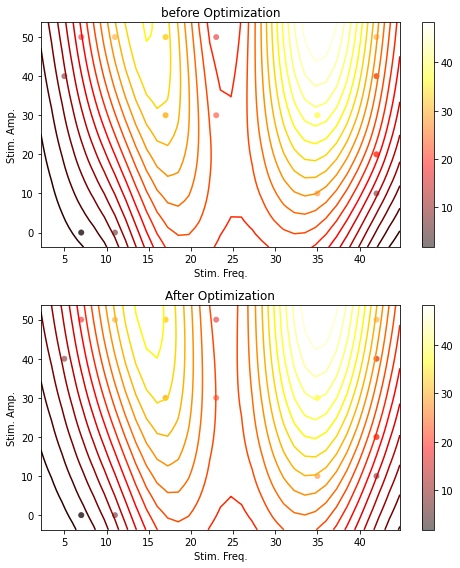

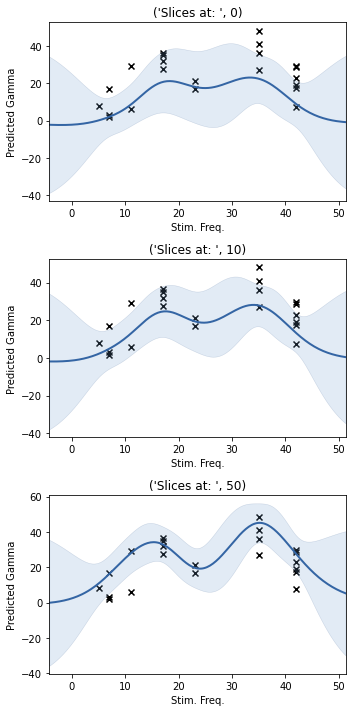

In [59]:
x_BaO, y_BaO, trained_model_BaO =model.initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

In [18]:
x_BaO, y_BaO, trained_model_BaO = model.bayes_opt_update_state(trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, 
                                                               ker_BaO, slice_dim, ylabel, initialize_data_dr_sim)

# initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

NameError: name 'sample' is not defined

### Acquisition Function draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end

##### the actual acquisition function is: upper_confidence_bound()

function ucb = upper_confidence_bound(Y_mean, Y_uncertainty, nu, t)

beta   	= 2 * log(t.^2*pi^2/(6));
ucb     = Y_mean + sqrt(nu*beta) * Y_uncertainty;

end

In [ ]:
nu = 0.1
# t = the sample we are on 
